In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Colab_Notebooks/CV2"

/content/drive/MyDrive/Colab_Notebooks/CV2


**Importing the Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
from glob import glob
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray

In [ ]:
# Loading the images file

data = np.load('Part 1- Train data - images.npy', allow_pickle=True)

In [ ]:
data.shape

(409, 2)

In [ ]:
data[0]

array([array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8),
       list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 

In [ ]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [ ]:
data[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

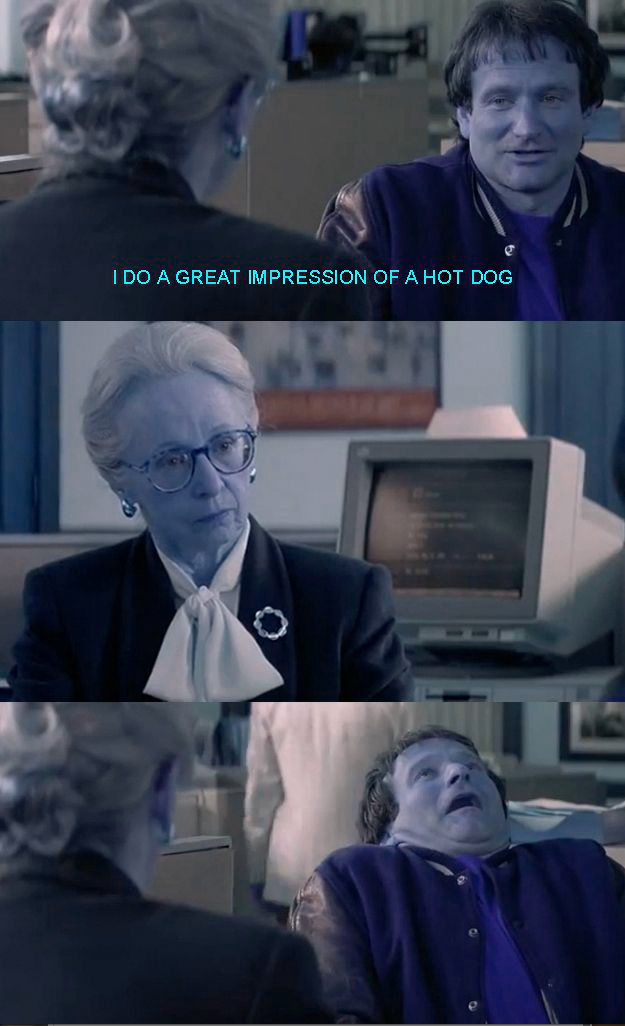

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(data[8][0])

In [ ]:
fi,ax = plt.subplots(10,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(30):
  ax[row][col].imshow(data[index][0], interpolation='nearest')
  index = index + 12
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  try:
    img = img[:,:,:3]   # discarding alpha channel
  except:
    print(f"Exception: {index} Grayscale image with shape {img.shape}")
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Channels standardized to 3
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Looping through face co-ordinates and creating mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # Setting all pixels within the mask co-ordinates as 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")


Exception: 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


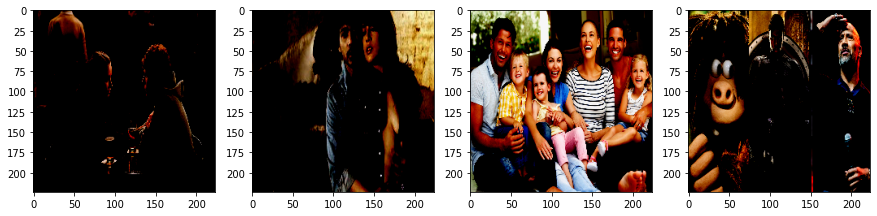

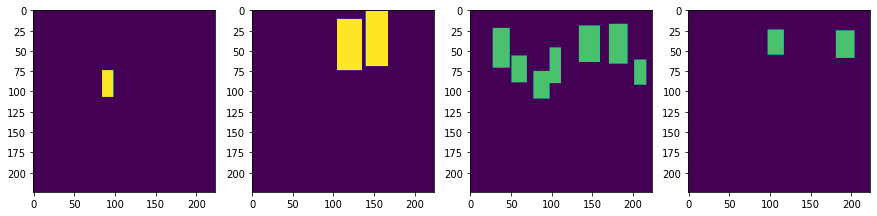

In [ ]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

# We can see good output even for multiple faces in an image, and also that faces out of focus are not detected.

**Creating Mask Detection Model using U-net adopting MobileNet Transfer Learning Model**

In [ ]:
IMAGE_SIZE = 224
EPOCHS = 20
BATCH = 8
LR = 1e-4

In [ ]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
model = model()
model.summary()

2031616/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                               

**Dice Coefficient and Loss function**

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/20
41/41 [==============================] - 52s 917ms/step - loss: 0.7156 - dice_coef: 0.2846 - recall: 0.7817 - precision: 0.2147 - val_loss: 0.7758 - val_dice_coef: 0.2218 - val_recall: 1.0000 - val_precision: 0.1168 - lr: 1.0000e-04
Epoch 2/20
41/41 [==============================] - 39s 950ms/step - loss: 0.5931 - dice_coef: 0.4066 - recall: 0.8884 - precision: 0.4036 - val_loss: 0.7512 - val_dice_coef: 0.2456 - val_recall: 0.9965 - val_precision: 0.1386 - lr: 1.0000e-04
Epoch 3/20
41/41 [==============================] - 40s 967ms/step - loss: 0.5515 - dice_coef: 0.4481 - recall: 0.8994 - precision: 0.4650 - val_loss: 0.7060 - val_dice_coef: 0.2890 - val_recall: 0.9874 - val_precision: 0.2059 - lr: 1.0000e-04
Epoch 4/20
41/41 [==============================] - 37s 910ms/step - loss: 0.5321 - dice_coef: 0.4679 - recall: 0.9017 - precision: 0.4980 - val_loss: 0.6420 - val_dice_coef: 0.3498 - val_recall: 0.9661 - val_precision: 0.3182 - lr: 1.0000e-04
Epoch 5/20
41/41 [======

**Model evaluation**

In [ ]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 0s 86ms/step - loss: 0.4604 - dice_coef: 0.5375 - recall: 0.6674 - precision: 0.7111


[0.4604247510433197,
 0.5375217795372009,
 0.6673557162284851,
 0.7111429572105408]

**Predicting an image that was not used for training and testing the model**

In [ ]:
filename = './Part 1Test Data - Prediction Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [ ]:
feat_scaled

array([[[ 0.5686275 ,  0.4666667 ,  0.45098042],
        [ 0.56078434,  0.45882356,  0.4431373 ],
        [ 0.5764706 ,  0.47450984,  0.45882356],
        ...,
        [-0.17647058, -0.5058824 , -0.73333335],
        [-0.27058822, -0.49019605, -0.75686276],
        [-0.27843136, -0.47450978, -0.7411765 ]],

       [[ 0.6       ,  0.49803925,  0.48235297],
        [ 0.6       ,  0.4901961 ,  0.48235297],
        [ 0.6313726 ,  0.5294118 ,  0.5137255 ],
        ...,
        [-0.20784312, -0.52156866, -0.7490196 ],
        [-0.16862744, -0.40392154, -0.6627451 ],
        [-0.19215685, -0.41176468, -0.6784314 ]],

       [[ 0.54509807,  0.45098042,  0.41960788],
        [ 0.47450984,  0.3803922 ,  0.34901965],
        [ 0.5372549 ,  0.4431373 ,  0.4039216 ],
        ...,
        [-0.14509803, -0.42745095, -0.6627451 ],
        [-0.3098039 , -0.5686275 , -0.827451  ],
        [-0.34117645, -0.5921569 , -0.8509804 ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [ ]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.10671785],
         [0.09956515],
         [0.09750503],
         ...,
         [0.09643418],
         [0.09582305],
         [0.11193615]],

        [[0.11268353],
         [0.07635805],
         [0.09373003],
         ...,
         [0.09640732],
         [0.08530515],
         [0.08948994]],

        [[0.10342857],
         [0.08297136],
         [0.09935293],
         ...,
         [0.10072204],
         [0.0906927 ],
         [0.09152079]],

        ...,

        [[0.10950565],
         [0.09477466],
         [0.09680125],
         ...,
         [0.09864441],
         [0.08440855],
         [0.09083375]],

        [[0.11044717],
         [0.08867922],
         [0.08537441],
         ...,
         [0.09467751],
         [0.08020473],
         [0.08467373]],

        [[0.10964492],
         [0.07486716],
         [0.08033791],
         ...,
         [0.09763351],
         [0.09041187],
         [0.08291659]]]], dtype=float32)

In [ ]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))

**Displaying the predicted image and its face-detection output**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


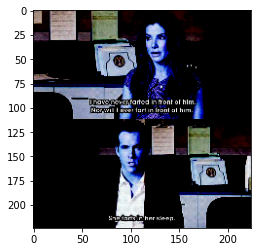

In [ ]:
plt.imshow(feat_scaled)

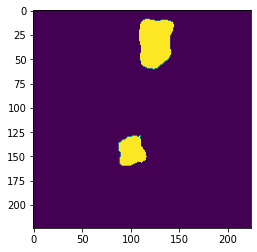

In [ ]:
plt.imshow(pred_mask)

The model was able to detect both faces in the image correctly.

# Part 3

In [ ]:
project_path = '/content/drive/MyDrive/Colab_Notebooks/CV2/'

**Unzipping the file**

In [ ]:
from zipfile import ZipFile

# specifying the zip file name
file_name = project_path + "Part 3 - Aligned Face Dataset from Pinterest.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    # zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...


KeyboardInterrupt: ignored

In [ ]:
directory = '/content/drive/MyDrive/Colab_Notebooks/CV2/pins/PINS/'

**Renaming images and extracting person's name**

In [ ]:
ls '/content/drive/MyDrive/Colab_Notebooks/CV2/pins/PINS/'

AARON_PAUL/                ELON_MUSK/             MORGAN_FREEMAN/
ALEXANDRA_DADDARIO/        EMILIA_CLARKE/         NATALIE_PORTMAN_/
ALVARO_MORTE/              EMILY_BETT_RICKARDS/   NEIL_PATRICK_HARRIS/
ALYCIA_DEBNAM_CAREY_FACE/  EMMA_STONE/            PAUL_RUDD/
AMANDA_CREW/               EMMA_WATSON_FACE/      PEDRO_ALONSO/
AMAURY_NOLASCO/            GAL_GADOT_FACE/        PETER_DINKLAGE/
AMBER_HEARD_FACE/          GRANT_GUSTIN_FACE/     RAMI_MELEK/
ANNA_GUNN/                 GWYNETH_PALTROW/       RIHANNA/
ANNE_HATHAWAY/             HENRY_CAVIL/           RJ_MITTE/
BARBARA_PALVIN_FACE/       JASON_ISAACS/          ROBERT_DOWNEY_JR_FACE/
BELLAMY_BLAKE_FACE/        JASON_MOMOA/           ROBERT_KNEPPER/
BENEDICT_CUMBERBATCH/      JEFF_BEZOS/            ROBIN_TAYLOR/
BETSY_BRANDT/              JEREMY_RENNER/         RYAN_REYNOLDS/
BILL_GATES/                JESSE_EISENBERG/       SARAH_WAYNE_CALLIES/
BRENTON_THWAITES/          JIM_PARSONS/           SCARLETT_JOHANSSON/
BRIE_LARSON/  

In [ ]:
for filename in os.listdir(directory):
    os.rename(os.path.join(directory,filename),os.path.join(directory, filename.replace(' ', '_').upper()))
    if "PINS_" in filename:    
        filepath = os.path.join(directory, filename)
        newfilepath = os.path.join(directory, filename.replace("PINS_", ""))
        os.rename(filepath, newfilepath)

for subdir, dirs, files in os.walk(directory):
    for file in files:
      os.rename(os.path.join(subdir, file), os.path.join(subdir, file.replace(' ', '_')))


**Displaying all the labels**

In [ ]:
from glob import glob
paths = glob("pins/PINS/*")
label_names = [os.path.split(x)[1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format((label_names)))

Total labels: 100
Labels: ['AARON_PAUL', 'ALVARO_MORTE', 'AMANDA_CREW', 'AMAURY_NOLASCO', 'ANNA_GUNN', 'BENEDICT_CUMBERBATCH', 'BETSY_BRANDT', 'BRENTON_THWAITES', 'BRIT_MARLING', 'BRYAN_CRANSTON', 'CAITY_LOTZ', 'CAMERON_MONAGHAN', 'CHANCE_PERDOMO', 'CHRIS_EVANS', 'CHRIS_PRATT', 'COBIE_SMULDERS', 'DANIELLE_PANABAKER', 'DAVE_FRANCO', 'DOMINIC_PURCELL', 'DWAYNE_JOHNSON', 'EMILIA_CLARKE', 'EMILY_BETT_RICKARDS', 'EMMA_STONE', 'GWYNETH_PALTROW', 'HENRY_CAVIL', 'JASON_MOMOA', 'JEREMY_RENNER', 'JESSE_EISENBERG', 'JIM_PARSONS', 'JON_BERNTHAL', 'JOSH_RADNOR', 'KIT_HARINGTON', 'KRYSTEN_RITTER', 'KUMAIL_NANJIANI', 'MAISIE_WILLIAMS', 'MARK_RUFFALO', 'MARTIN_STARR', 'MELISSA_BENOIT', 'MIKE_COLTER', 'MORENA_BACCARIN', 'MORGAN_FREEMAN', 'NATALIE_PORTMAN_', 'NEIL_PATRICK_HARRIS', 'PAUL_RUDD', 'PEDRO_ALONSO', 'PETER_DINKLAGE', 'RJ_MITTE', 'RAMI_MELEK', 'ROBERT_KNEPPER', 'ROBIN_TAYLOR', 'RYAN_REYNOLDS', 'SARAH_WAYNE_CALLIES', 'SCARLETT_JOHANSSON', 'SEBASTIAN_STAN', 'SOPHIE_TURNER', 'STEPHEN_AMELL', 'SUND

**Saving metadata in a dataframe**

In [ ]:
df = pd.DataFrame(columns=['Person', 'No. of Images','File Path', 'Files'])

folders = [x[0] for x in os.walk(directory)]

for subfolders in folders:
  fileList = os.listdir(subfolders)
  filePath = os.path.abspath(subfolders)
  person = (subfolders)[len(directory):]
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)

df

,Person,No. of Images,File Path,Files
0,,100,/content/drive/MyDrive/Colab_Notebooks/CV2/pin...,"[AARON_PAUL, ALVARO_MORTE, AMANDA_CREW, AMAURY..."
1,AARON_PAUL,86,/content/drive/MyDrive/Colab_Notebooks/CV2/pin...,"[Aaron_Paul0_262.jpg, Aaron_Paul101_247.jpg, A..."
2,ALVARO_MORTE,91,/content/drive/MyDrive/Colab_Notebooks/CV2/pin...,"[Alvaro_Morte100_825.jpg, Alvaro_Morte101_873...."
3,AMANDA_CREW,118,/content/drive/MyDrive/Colab_Notebooks/CV2/pin...,"[Amanda_Crew0.jpg, Amanda_Crew1.jpg, Amanda_Cr..."
4,AMAURY_NOLASCO,113,/content/drive/MyDrive/Colab_Notebooks/CV2/pin...,"[Amaury_Nolasco0.jpg, Amaury_Nolasco1.jpg, Ama..."
...,...,...,...,...
96,SHAKIRA,50,/content/drive/MyDrive/Colab_Notebooks/CV2/pin...,"[shakira0.jpg, shakira1.jpg, shakira10.jpg, sh..."
97,TATI_GABRIELLE,65,/content/drive/MyDrive/Colab_Notebooks/CV2/pin...,"[tati_gabrielle0.jpg, tati_gabrielle1.jpg, tat..."
98,TAYLOR_SWIFT,99,/content/drive/MyDrive/Colab_Notebooks/CV2/pin...,"[taylor_swift0.jpg, taylor_swift1.jpg, taylor_..."
99,TOM_HOLLAND_FACE,119,/content/drive/MyDrive/Colab_Notebooks/CV2/pin...,"[tom_holland_face0.jpg, tom_holland_face1.jpg,..."


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(1, (300, 100))
grid = ImageGrid(fig, 111, nrows_ncols=(100, 10), axes_pad=0.1)

n_img_class = []
counter = 0
for idx, label in enumerate(label_names):
    paths = glob(os.path.join("pins/PINS", label, "*.jpg"))
    n_img_class.append([label, len(paths)])
    perm = np.random.choice(len(paths), size=10)

    title = True
    for ii in perm:
        ax = grid[counter]
        if title:
            ax.text(1800, 105, label, verticalalignment="center")
            title = False
        img = cv2.imread(paths[ii])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
        
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Creating the features and target sets**

In [ ]:
TRAIN_FOLDER= "pins/PINS"

In [ ]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # ignore missing values
          missing += 1
          continue
        images.append(image_bgr)
        classes.append(class_label)

In [ ]:
len(images)

10770

**Preprocessing**

In [ ]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [ ]:
images[0].shape

(224, 224, 3)

In [ ]:
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (10770, 224, 224, 3)
classes shape:  (10770,)


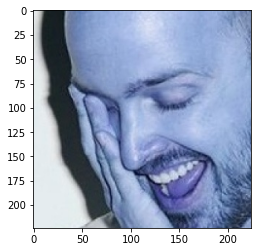

In [ ]:
plt.imshow(images[49])

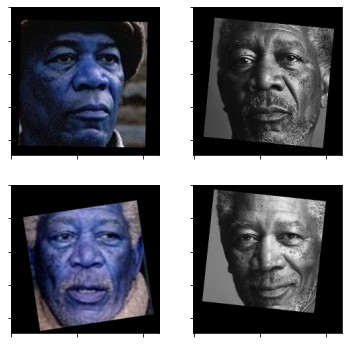

In [ ]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("MORGAN_FREEMAN")

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata(directory)

In [ ]:
!pip install keras_vggface

**Loading the pretrained vggface weights**

In [ ]:
weights_file = project_path + 'Part 3 - vgg_face_weights.h5'

**Creating a VGG Face Model**

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights(weights_file)

In [ ]:
vgg_face_descriptor=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output) 

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.3 MB/s 


In [ ]:
import mtcnn

In [ ]:
cd '/content/drive/MyDrive/Colab_Notebooks/CV2/pics'

/content/drive/MyDrive/Colab_Notebooks/CV2/pics


**Viewing a sample image**

In [ ]:
sample_pic = 'Sundar_Pichai2_740.jpg'

image = plt.imread(sample_pic)
plt.imshow(image)

FileNotFoundError: ignored

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from mtcnn.mtcnn import MTCNN

# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(image)
for face in faces:
  print(face)


{'box': [114, 13, 27, 39], 'confidence': 0.9635218381881714, 'keypoints': {'left_eye': (118, 29), 'right_eye': (132, 28), 'nose': (122, 37), 'mouth_left': (121, 44), 'mouth_right': (131, 43)}}
{'box': [88, 125, 28, 41], 'confidence': 0.8452343940734863, 'keypoints': {'left_eye': (95, 141), 'right_eye': (108, 141), 'nose': (101, 150), 'mouth_left': (97, 157), 'mouth_right': (107, 158)}}


In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
def highlight_faces(image_path, faces):
  # display image
    image = plt.imread(image_path)
    plt.imshow(image)

    ax = plt.gca()

    # for each face, draw a rectangle based on coordinates
    for face in faces:
        x, y, width, height = face['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

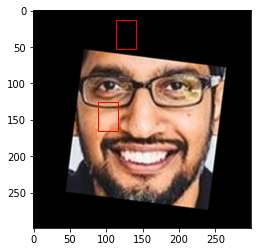

In [ ]:
highlight_faces('Sundar_Pichai2_740.jpg', faces)

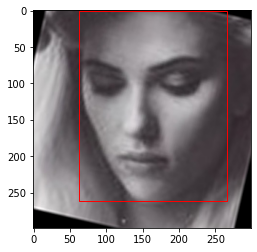

In [ ]:
image = plt.imread('Scarlett_Johansson4.jpg')
faces = detector.detect_faces(image)

highlight_faces('Scarlett_Johansson4.jpg', faces)

In [ ]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	pixels = cv2.imread(filename)
 
	detector = MTCNN()
 
	results = detector.detect_faces(pixels)
 
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height

	face = pixels[y1:y2, x1:x2]

	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

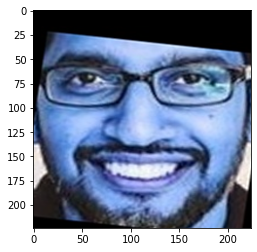

In [ ]:
pixels = extract_face('Sundar_Pichai2_740.jpg')
# plot the extracted face
plt.imshow(pixels)
plt.show()

In [ ]:
pip install keras_vggface

In [ ]:
pip install keras_applications

     |████████████████████████████████| 50 kB 2.9 MB/s 


In [ ]:
from numpy import expand_dims
from keras.applications.vgg16 import VGG16
from keras_vggface.utils import preprocess_input

pixels = extract_face('Sundar_Pichai2_740.jpg')
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)
samples = preprocess_input(samples, version=2)

In [ ]:
from keras_vggface.utils import decode_predictions

yhat = vgg_face_descriptor.predict(samples)
results = decode_predictions(yhat)

for result in results[0]:
	print('%s: %.2f%%' % (result[0], result[1]))

360448/346184 [===============================] - 0s 0us/step
b'Nick_Kroll': 15.12%
b'Michael_Steger': 13.11%
b'Paul_Scheer': 11.17%
b'Irrfan_Khan': 10.78%
b'Nicholas_Gonzalez': 10.65%


The model was able to predict the image correctly but with less confidence level

In [ ]:
def get_embeddings(filenames):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)

	# perform prediction
	yhat = vgg_face_descriptor.predict(samples)
	return yhat

**Defining functions to measure the distance between two different images to find how identical they are**

In [ ]:
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

In [ ]:
from scipy.spatial.distance import cosine

filenames = ['bill_gates2.jpg','bill_gates3.jpg','bill_gates16.jpg','jeff_bezos2.jpg']
embeddings = get_embeddings(filenames)
bill_id = embeddings[0]
print('Positive Tests')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
print('Negative Tests')
is_match(embeddings[0], embeddings[3])

IndexError: ignored

In [96]:
def L2Norm(H1,H2):
    distance =0
    for i in range(len(H1)):
        distance += np.square(H1[i]-H2[i])
    return np.sqrt(distance)

In [97]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {L2Norm(embeddings[0], embeddings[2]):.2f}')
    plt.subplot(121)
    img_1 = plt.imread(filenames[idx1])
    plt.imshow(img_1)
    plt.subplot(122)
    img_2 = plt.imread(filenames[idx2])
    plt.imshow(img_2)    

show_pair(0, 2)

NameError: ignored

<Figure size 576x216 with 0 Axes>

In [98]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y = enc.fit_transform(classes)

num_classes = len(np.unique(y))
num_classes

100

In [99]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [100]:
random_seed = 2
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [101]:
print(f"# Shapes of Train, Test and Validation sets are: {X_train.shape},{X_test.shape},{X_val.shape}")

# Shapes of Train, Test and Validation sets are: (7539, 224, 224, 3),(1615, 224, 224, 3),(1616, 224, 224, 3)


In [102]:
print(f"# Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

# Shapes of Train, Test and Validation sets of Target are: (7539,),(1615,),(1616,)


In [103]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [104]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

In [105]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((1616, 50176), (1616, 50176), (1616, 50176))

In [106]:
from sklearn.decomposition import PCA as RandomizedPCA

n_components = 500
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [107]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [108]:
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.966874702551052, 0.9680109131457075, 0.9722817035656852)

In [109]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

In [110]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,
X_val_pca.shape, y_val.shape

((1616, 1500), (1616,))

In [111]:
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [112]:
X_train.shape[0]

7539

In [113]:
y_train.shape[0]

7539

In [114]:
svm_score = clf.score(X_val_pca, y_val)

In [115]:
from sklearn import svm, metrics

y_pred = clf.predict(X_test_pca)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)

**Prediction using SVM**

In [117]:
image = 'mark_zuckerberg55.jpg'
img_pred = plt.imread(image)
img_pred_resize = cv2.resize(img_pred,(224,224), interpolation = cv2.INTER_CUBIC)
img_predict = np.expand_dims(img_pred_resize, axis=0)

pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [118]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [119]:
pred_svm = clf.predict(X_pred_pca)[0]

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'61'


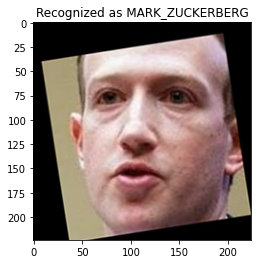

In [120]:
example_identity = enc.inverse_transform(np.ravel(pred_svm))[0]

plt.imshow(img_pred_resize)
plt.title(f'Recognized as {example_identity}');

In [121]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Predicted Person'])

model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Predicted Person': example_identity                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Predicted Person
0,SVM,0.021053,MARK_ZUCKERBERG
